In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
import json
from scipy.stats import linregress
import scipy.stats as st
import csv
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.dates as md
import seaborn as sns
from datetime import datetime, timedelta

sealevel_path = "Resources/GMSL_TPJAOS_5.1.csv"
sea_df = pd.read_csv(sealevel_path)

sea_df 

,altimeter_type,merged_file_cycle,year_fraction,num_observations,weighted_observations,GMSL_variation_no_GIA,std_dev_no_GIA,smoothed_GMSL_no_GIA,GMSL_variation_with_GIA,std_dev_with_GIA,smoothed_GMSL_with_GIA,GMSL_removed_annual_signal_no_GIA,GMSL_removed_annual_signal_with_GIA
0,0,11,1993.011526,466881,338409.69,-37.91,89.01,-37.67,-37.90,89.01,-37.66,-37.64,-37.65
1,0,12,1993.038692,459563,333609.59,-40.95,89.95,-39.07,-40.94,89.95,-39.06,-38.53,-38.54
2,0,13,1993.065858,402996,292736.50,-41.09,86.90,-39.11,-41.07,86.90,-39.09,-38.16,-38.18
3,0,14,1993.093025,462894,336670.31,-43.38,88.73,-39.40,-43.36,88.73,-39.38,-38.12,-38.14
4,0,15,1993.120191,460498,332486.09,-38.66,89.87,-38.51,-38.63,89.87,-38.48,-36.96,-36.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,0,1171,2024.503705,465272,338301.31,62.31,85.23,62.63,69.98,85.35,70.31,72.98,65.30
1160,0,1172,2024.530797,458794,335301.81,64.13,85.50,62.54,71.85,85.81,70.24,71.99,64.29
1161,0,1173,2024.557889,459567,335900.31,61.93,88.04,62.49,69.63,88.43,70.18,70.87,63.18
1162,0,1174,2024.584981,457215,334466.81,62.00,88.66,62.45,69.70,89.11,70.15,69.69,61.99


In [ ]:
sea_df.columns

In [9]:
clean_sea_df = sea_df.iloc[:, [2,5,6,7,8,9,10,11,12]]
clean_sea_df

,year_fraction,GMSL_variation_no_GIA,std_dev_no_GIA,smoothed_GMSL_no_GIA,GMSL_variation_with_GIA,std_dev_with_GIA,smoothed_GMSL_with_GIA,GMSL_removed_annual_signal_no_GIA,GMSL_removed_annual_signal_with_GIA
0,1993.011526,-37.91,89.01,-37.67,-37.90,89.01,-37.66,-37.64,-37.65
1,1993.038692,-40.95,89.95,-39.07,-40.94,89.95,-39.06,-38.53,-38.54
2,1993.065858,-41.09,86.90,-39.11,-41.07,86.90,-39.09,-38.16,-38.18
3,1993.093025,-43.38,88.73,-39.40,-43.36,88.73,-39.38,-38.12,-38.14
4,1993.120191,-38.66,89.87,-38.51,-38.63,89.87,-38.48,-36.96,-36.99
...,...,...,...,...,...,...,...,...,...
1159,2024.503705,62.31,85.23,62.63,69.98,85.35,70.31,72.98,65.30
1160,2024.530797,64.13,85.50,62.54,71.85,85.81,70.24,71.99,64.29
1161,2024.557889,61.93,88.04,62.49,69.63,88.43,70.18,70.87,63.18
1162,2024.584981,62.00,88.66,62.45,69.70,89.11,70.15,69.69,61.99


In [10]:
def convert_decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    days_in_year = 366 if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0) else 365
    days = (decimal_year - year) * days_in_year
    date = datetime(year, 1, 1) + timedelta(days=int(days))
    return date.strftime("%Y/%m/%d")


clean_sea_df["date_formatted"] = clean_sea_df ['year_fraction'].apply(convert_decimal_year_to_date)
clean_sea_df

/var/folders/zd/q6qh7xnd63q_4jpd7s3jwkt00000gn/T/ipykernel_78899/200188025.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_sea_df["date_formatted"] = clean_sea_df ['year_fraction'].apply(convert_decimal_year_to_date)


,year_fraction,GMSL_variation_no_GIA,std_dev_no_GIA,smoothed_GMSL_no_GIA,GMSL_variation_with_GIA,std_dev_with_GIA,smoothed_GMSL_with_GIA,GMSL_removed_annual_signal_no_GIA,GMSL_removed_annual_signal_with_GIA,date_formatted
0,1993.011526,-37.91,89.01,-37.67,-37.90,89.01,-37.66,-37.64,-37.65,1993/01/05
1,1993.038692,-40.95,89.95,-39.07,-40.94,89.95,-39.06,-38.53,-38.54,1993/01/15
2,1993.065858,-41.09,86.90,-39.11,-41.07,86.90,-39.09,-38.16,-38.18,1993/01/25
3,1993.093025,-43.38,88.73,-39.40,-43.36,88.73,-39.38,-38.12,-38.14,1993/02/03
4,1993.120191,-38.66,89.87,-38.51,-38.63,89.87,-38.48,-36.96,-36.99,1993/02/13
...,...,...,...,...,...,...,...,...,...,...
1159,2024.503705,62.31,85.23,62.63,69.98,85.35,70.31,72.98,65.30,2024/07/03
1160,2024.530797,64.13,85.50,62.54,71.85,85.81,70.24,71.99,64.29,2024/07/13
1161,2024.557889,61.93,88.04,62.49,69.63,88.43,70.18,70.87,63.18,2024/07/23
1162,2024.584981,62.00,88.66,62.45,69.70,89.11,70.15,69.69,61.99,2024/08/02


In [11]:
threshold_date = '2003/12/31'

filter_sea_df = clean_sea_df.loc[clean_sea_df['date_formatted'] > threshold_date]
filter_sea_df

,year_fraction,GMSL_variation_no_GIA,std_dev_no_GIA,smoothed_GMSL_no_GIA,GMSL_variation_with_GIA,std_dev_with_GIA,smoothed_GMSL_with_GIA,GMSL_removed_annual_signal_no_GIA,GMSL_removed_annual_signal_with_GIA,date_formatted
405,2004.008316,-6.44,83.94,-4.41,-3.77,83.93,-1.73,-1.78,-4.46,2004/01/04
406,2004.035407,-1.75,86.13,-4.49,0.93,86.22,-1.81,-1.34,-4.02,2004/01/13
407,2004.062499,-2.20,85.43,-4.85,0.48,85.51,-2.17,-1.28,-3.96,2004/01/23
408,2004.089591,-4.58,82.78,-5.50,-1.89,82.76,-2.81,-1.59,-4.28,2004/02/02
409,2004.116683,-10.81,83.51,-6.23,-8.13,83.37,-3.52,-2.03,-4.74,2004/02/12
...,...,...,...,...,...,...,...,...,...,...
1159,2024.503705,62.31,85.23,62.63,69.98,85.35,70.31,72.98,65.30,2024/07/03
1160,2024.530797,64.13,85.50,62.54,71.85,85.81,70.24,71.99,64.29,2024/07/13
1161,2024.557889,61.93,88.04,62.49,69.63,88.43,70.18,70.87,63.18,2024/07/23
1162,2024.584981,62.00,88.66,62.45,69.70,89.11,70.15,69.69,61.99,2024/08/02


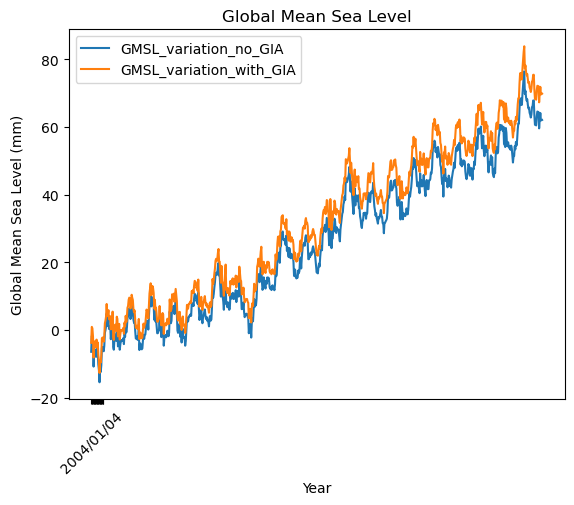

In [24]:


ax = filter_sea_df.plot(x='date_formatted', y= ['GMSL_variation_no_GIA','GMSL_variation_with_GIA'])
#ax.xaxis.set_major_formatter(md.DateFormatter('%Y'))
years = list(range(2004, 2025))
plt.xticks(range(len(years)), rotation = 45)
#ax.set_xticklabels(years)
plt.xlabel('Year')
plt.ylabel('Global Mean Sea Level (mm)')
plt.title('Global Mean Sea Level')
plt.show()